## Import Library

In [1]:
import os
import math
import re
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from fast_ml.model_development import train_valid_test_split
import scipy.stats as stats
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

## Load Data

In [2]:
data_path = os.path.join("dataset", "loan_data_2007_2014.csv")
loan_df = pd.read_csv(data_path, low_memory=False, index_col=0)

In [3]:
# drop columns that filled with all NaN values
loan_df = loan_df.dropna(axis = 1, how = "all")
# drop duplicated data
loan_df = loan_df.drop_duplicates()
loan_df.shape

(466285, 57)

In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [5]:
loan_df = loan_df.drop(["id", "member_id"], axis=1)

In [6]:
check_missing = loan_df.isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
desc                           72.981546
mths_since_last_delinq         53.690554
next_pymnt_d                   48.728567
total_rev_hi_lim               15.071469
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_title                       5.916553
emp_length                      4.505399
last_pymnt_d                    0.080637
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
last_credit_pull_d              0.009007
inq_last_6mths                  0.006219
open_acc                        0.006219
total_acc                       0.006219
earliest_cr_line                0.006219
delinq_2yrs                     0.006219
acc_now_delinq                  0.006219
pub_rec                         0.006219
title                           0.004289
annual_inc                      0.000858
dtype: float64

In [7]:
col_names = check_missing[check_missing < 75].index.tolist()
for i in loan_df[col_names] :
    print(f"{i} : {loan_df[i].unique()}")

loan_amnt : [ 5000  2500  2400 ... 33675 27775 33175]
funded_amnt : [ 5000  2500  2400 ... 27775 33175 31725]
funded_amnt_inv : [ 4975.  2500.  2400. ... 30425. 33125. 33625.]
term : [' 36 months' ' 60 months']
int_rate : [10.65 15.27 15.96 13.49 12.69  7.9  18.64 21.28 14.65  9.91 16.29  6.03
 11.71 12.42 14.27 16.77  7.51  8.9  18.25  6.62 19.91 17.27 17.58 21.67
 19.42 22.06 20.89 20.3  23.91 19.03 23.52 23.13 22.74 22.35 24.11  6.
 22.11  7.49 11.99  5.99 10.99  9.99 18.79 11.49  8.49 15.99 16.49  6.99
 12.99 15.23 14.79  5.42 10.59 17.49 15.62 21.36 19.29 13.99 18.39 16.89
 17.99 20.62 20.99 22.85 19.69 20.25 23.22 21.74 22.48 23.59 12.62 18.07
 11.63  7.91  7.42 11.14 20.2  12.12 19.39 16.11 17.54 22.64 13.84 16.59
 17.19 12.87 20.69  9.67 21.82 19.79 18.49 22.94 24.59 24.4  21.48 14.82
 14.17  7.29 17.88 20.11 16.02 17.51 13.43 14.91 13.06 15.28 15.65 17.14
 11.11 10.37 16.4   7.66 10.   18.62 10.74  5.79  6.92  9.63 14.54 12.68
 19.36 13.8  18.99 21.59 20.85 21.22 19.74 20.48  

In [8]:
drop_cols = check_missing[check_missing > 75].index.tolist() + [
                                                                "sub_grade",
                                                                "emp_title",
                                                                "url",
                                                                "desc",
                                                                "title",
                                                                "zip_code",
                                                                "policy_code",
                                                                "application_type",
                                                                "funded_amnt_inv",
                                                                "out_prncp_inv",
                                                                "total_pymnt_inv",
                                                                "total_pymnt_inv"
                                                            ]
loan_df = loan_df.drop(drop_cols, axis=1)

In [9]:
loan_df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN


## Data Cleaning, Feature Engineering

### Define target

In [10]:
loan_df['loan_status'].value_counts(normalize=True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [11]:
loan_df['loan_status'].isnull().sum()/len(loan_df)*100

0.0

In [12]:
def status_labeler(status):
    RISK_NAME = r"late|current|in grace period|fully paid"
    RISK = re.compile(
        RISK_NAME
    )
    LOAN_STATUS = status.lower()
    extract = RISK.search(LOAN_STATUS)
    if extract != None :
        ext_group = extract.group()
        if (ext_group == r"fully paid") :
            state = "excellent"
        elif (ext_group == r"current") or (ext_group == r"in grace period") :
            state = "good"
        elif (ext_group == r"late") : 
            state = "fair"
    else : 
        state = "poor"
    return state

In [13]:
loan_df["credit_risk"] = loan_df["loan_status"].apply(status_labeler)
loan_df["credit_risk"].value_counts(normalize=True)*100

good         48.762452
excellent    40.045680
poor          9.450872
fair          1.740995
Name: credit_risk, dtype: float64

### emp_length

In [14]:
loan_df = loan_df.drop(["loan_status"], axis=1)

In [15]:
loan_df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [16]:
loan_df['emp_length_int'] = loan_df['emp_length'].str.replace(r"\+ years|\ years|\ year", '', regex=True)
loan_df['emp_length_int'] = loan_df['emp_length_int'].str.replace('< 1', str(0))
loan_df['emp_length_int'] = loan_df['emp_length_int'].astype(float)

In [17]:
loan_df = loan_df.drop(["emp_length"], axis=1)

### term

In [18]:
loan_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [19]:
loan_df['term'] = loan_df['term'].str.replace('\ months', '')
loan_df['term'] = loan_df['term'].str.replace(' ', '')

In [20]:
loan_df['term'].unique()

array(['36', '60'], dtype=object)

### earliest_cr_line

In [21]:
loan_df['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [22]:
loan_df['earliest_cr_line_date'] = pd.to_datetime(loan_df['earliest_cr_line'], format='%b-%y')
loan_df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [23]:
loan_df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
loan_df['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [24]:
loan_df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [25]:
loan_df[loan_df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(2)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0


In [26]:
loan_df.loc[loan_df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = loan_df['mths_since_earliest_cr_line'].max()

In [27]:
loan_df = loan_df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1)

### issue_d

In [28]:
loan_df['issue_d_date'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y')
loan_df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['issue_d_date']) / np.timedelta64(1, 'M')))

In [29]:
loan_df['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [30]:
loan_df = loan_df.drop(['issue_d', 'issue_d_date'], axis=1)

### last_pymnt_d

In [31]:
loan_df['last_pymnt_d_date'] = pd.to_datetime(loan_df['last_pymnt_d'], format='%b-%y')
loan_df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [32]:
loan_df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [33]:
loan_df = loan_df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1)

### next_pymnt_d

In [34]:
loan_df['next_pymnt_d_date'] = pd.to_datetime(loan_df['next_pymnt_d'], format='%b-%y')
loan_df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [35]:
loan_df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.738136
std           6.082298
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         120.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [36]:
loan_df = loan_df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1)

### last_credit_pull_d

In [37]:
loan_df['last_credit_pull_d_date'] = pd.to_datetime(loan_df['last_credit_pull_d'], format='%b-%y')
loan_df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [38]:
loan_df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [39]:
loan_df = loan_df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1)

### home_ownership

In [40]:
loan_df["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [41]:
def home_ownership_simplify(status):
    SIMPLIFY = re.compile(
            r"none|any"
        )
    OWNERSHIP_STATUS = status.lower()
    extract = SIMPLIFY.search(OWNERSHIP_STATUS)
    if bool(extract) == True:
        state = "OTHER"
    else :
        state = status
    return state

In [42]:
loan_df["home_ownership_new"] = loan_df["home_ownership"].apply(home_ownership_simplify)

In [43]:
loan_df["home_ownership_new"].value_counts(normalize=True)*100

MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
OTHER        0.049969
Name: home_ownership_new, dtype: float64

In [44]:
loan_df = loan_df.drop(["home_ownership"], axis=1)

## Data Visualization

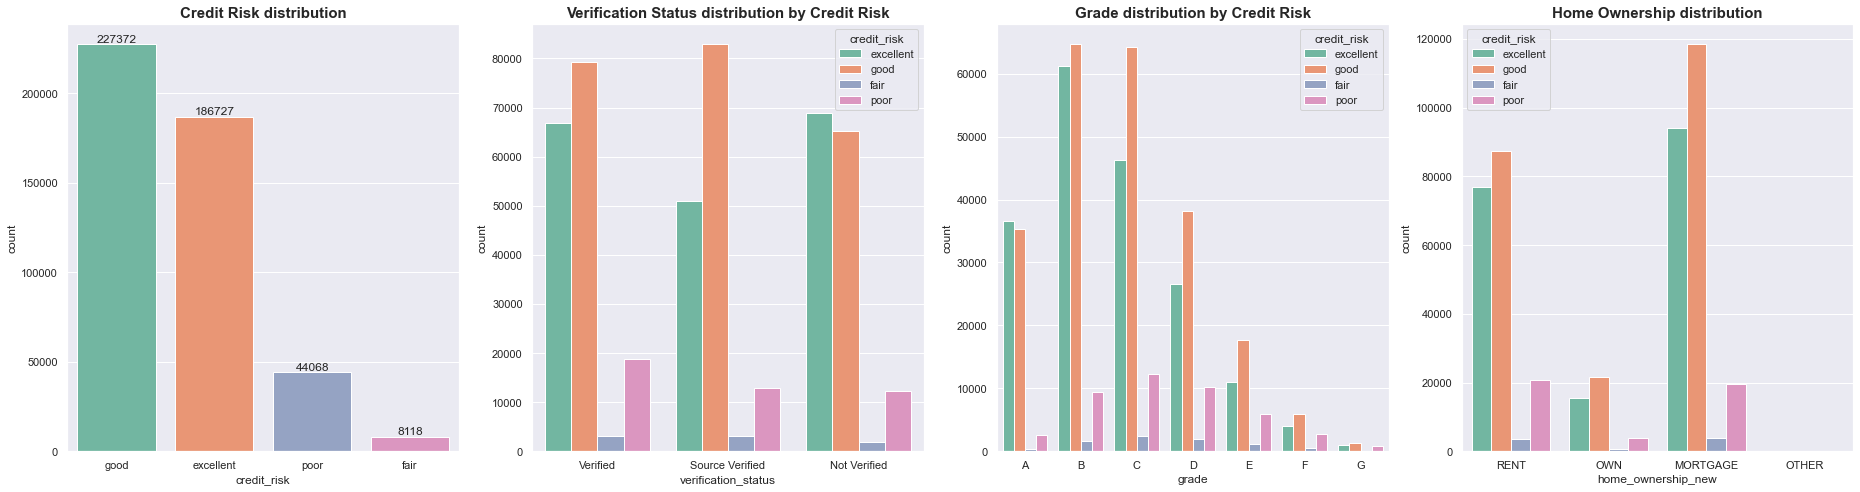

In [45]:
plt.figure(figsize=(26, 7))
plt.subplot(141)
abs_values = loan_df["credit_risk"].value_counts(ascending=False).values
ax = sns.countplot(
    x= "credit_risk",
    data= loan_df,
    order=loan_df["credit_risk"].value_counts().index,
    palette='Set2'
)
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.title("Credit Risk distribution",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(142)
sns.countplot(
    x= "verification_status",
    data= loan_df,
    hue = "credit_risk",
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Verification Status distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(143)
sns.countplot(
    x= "grade",
    data= loan_df,
    hue = "credit_risk",
    order=["A", "B", "C", "D", "E", "F", "G"],
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Grade distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(144)
sns.countplot(
    x= "home_ownership_new",
    hue = "credit_risk",
    data= loan_df,
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Home Ownership distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [95]:
model_data = loan_df

In [96]:
LE = LabelEncoder()
LE.fit(model_data["credit_risk"])

LabelEncoder()

### Data Splitting

In [97]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_data, target = 'credit_risk', 
                                                                            train_size=0.7, valid_size=0.2, test_size=0.1, random_state=42)

In [98]:
X_train_join = pd.concat([X_train, y_train], axis=1)
X_valid_join = pd.concat([X_valid, y_valid], axis=1).dropna(axis = 0, how = "any")
X_test_join = pd.concat([X_test, y_test], axis=1).dropna(axis = 0, how = "any")

In [99]:
X_valid = X_valid_join.drop(["credit_risk"], axis=1)
X_test = X_test_join.drop(["credit_risk"], axis=1)
y_valid = LE.transform(X_valid_join["credit_risk"])
y_test = LE.transform(X_test_join["credit_risk"])

In [100]:
print('X_train dataset shape:',X_train.shape)
print('X_valid dataset shape:',X_valid.shape)
print('X_test dataset shape:',X_test.shape)
print('y_train dataset shape:',y_train.shape)
print('y_valid dataset shape:',y_valid.shape)
print('y_test dataset shape:',y_test.shape)

X_train dataset shape: (326399, 41)
X_valid dataset shape: (21556, 41)
X_test dataset shape: (10842, 41)
y_train dataset shape: (326399,)
y_valid dataset shape: (21556,)
y_test dataset shape: (10842,)


### Outlier Handling

In [101]:
# Handle outliers from X_train_join
num_col = X_train_join.select_dtypes(exclude='object').columns.tolist()

### Missing Value

### Feature Selection

## ML Model